In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')
#pd.options.display.float_format = "{:,.2f}".format

# Introduction  

In this analysis, I will be building a forecasting (SARIMA) model to trade stocks, particularly:
  1. Tesla
  2. Apple
  3. Amazon
  4. General Electric
  5. Boeing

I will be using data from January 1, 2019 though March 28, 2019 for training, and then evaluate this model on April 2019 data. First lets get the stock data.

In [2]:
def get_stock_data(ticker, start_date, end_date):
    df = web.DataReader(ticker, 'yahoo', start_date, end_date)
    df.reset_index(inplace=True)
    df = df[['Date', 'Adj Close']]
    df.columns = ['ds', 'y']
    return df

In [3]:
# We would like all available data from 01/01/2000 until 12/31/2016.
# can only go back to 2019-04-29 with Bloomberg
start_date = dt.datetime(2019,1,1)
end_date = dt.datetime(2019,4,29)

tesla = get_stock_data('TSLA', start_date, end_date)
apple = get_stock_data('AAPL', start_date, end_date)
amazon = get_stock_data('AMZN', start_date, end_date)
ge = get_stock_data('GE', start_date, end_date)
boeing = get_stock_data('BA', start_date, end_date)

In [4]:
tesla.head()

,ds,y
0,2019-01-02,310.119995
1,2019-01-03,300.359985
2,2019-01-04,317.690002
3,2019-01-07,334.959991
4,2019-01-08,335.350006


# SARIMA  

The Seasonal Autoregressive Integrated Moving Average, or SARIMA, model is an approach for modeling univariate time series data that may contain trend and seasonal components. It is an extension on ARIMA models, including new hyperparameters to specify the autoregression (AR), differencing (I), and moving average (MA) for the seasonal component of the series.

Configurations for a SARIMA models include 7 different hyperparameters:
  * **ARIMA**  
    * **p**: Trend autoregression order.
    * **d**: Trend difference order.
    * **q**: Trend moving average order
  * **Seasonal**  
    * **P**: Seasonal autoregressive order.
    * **D**: Seasonal difference order.
    * **Q**: Seasonal moving average order.
    * **m**: The number of time steps for a single seasonal period.
  
The trend and seasonal hyperparameters of the model can be configured by analyzing autocorrelation and partial autocorrelation plots, and this can take some expertise. I will use this information, as well as grid searching the hyperparameter space as configurations may not be intuitive. (As this space can get quite large, I will offload this task to more optimized hardware, in this case on [Kaggle](https://www.kaggle.com/mjmurphy28/grid-search-for-sarima).) I will use the implementation of SARIMA provided by the statsmodels library.

This model has hyperparameters that control the nature of the model performed for the series, trend and seasonality, specifically:

  * **order**: A tuple p, d, and q parameters for the modeling of the trend.
  * **sesonal order**: A tuple of P, D, Q, and m parameters for the modeling the seasonality
  * **trend**: A parameter for controlling a model of the deterministic trend as one of ‘n’,’c’,’t’,’ct’ for no trend, constant, linear, and constant with linear trend, respectively.
  
As mentioned above, we can inspect autocorrelation and partial autocorrelation plots in order to determine these parameters, however, I will be developing a grid search framework which will optimize these parameters to minimize error. In this case, I have determined that mean absolute percentage error (MAPE) works better for stock forecasting, as RMSE does not account for the magnitude of assets: 1 share of Google is now at \\$1,095.73 and 1 share of Microsoft is at \\$134.87, so a 1\% decrease for both would result in a loss of \\$10.96 for Google but only a loss of \\$1.35 for Microsoft.

In [7]:
from math import sqrt
from multiprocessing import cpu_count
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
 
# Direct method for SARIMA forecast
# A new model for every prediction
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

def mean_absolute_percentage_error(y_true, y_pred):
    '''Take in true and predicted values and calculate the MAPE score.'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = mean_absolute_percentage_error(test, predictions)
    return predictions, error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                predictions, result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return predictions, result

_We will use mean absolute percent error as our metric to optimize on._

In [9]:
def mape(data):
    return np.mean(np.abs(data['y'].diff()[1:] / data['y'].shift()[1:])) * 100

## Tesla 

In [75]:
n_test = 10 # horizon of 2 business weeks
mape(tesla[:-n_test])

2.165574415550332

In [76]:
# 1 - split the data
data = tesla['y'].values
#int(0.2*len(tesla))
train, test = data[:-n_test], data[-n_test:]

**Kurtosis**  

We first calculate our daily returns, and then from this we calculate a rolling Kurtosis of our returns. If we assume that the daily returns are stationary (follows a normal distribution), then the Kurtosis value gives us an indication of where on the normal curve the previous 5 days of returns falls - the further away from 0 the more extreme the returns. Ideally, we want to avoid stocks that have rolling Kurtosis values greater than 1 or less than -1. 

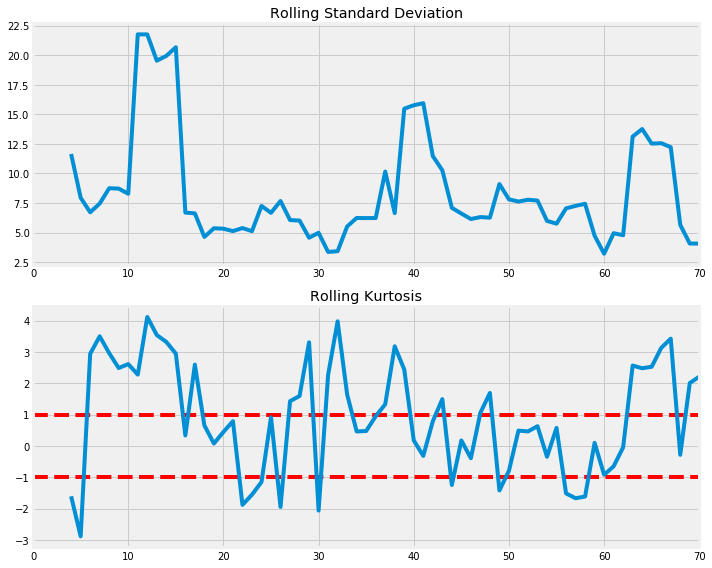

In [48]:
# calculate the returns
returns = np.diff(train)
s = pd.Series(returns)

plt.figure(1, figsize=(10,8))
plt.subplot(211)
s.rolling(5).std().plot()
plt.title('Rolling Standard Deviation')

plt.subplot(212)
plt.title('Rolling Kurtosis')
s.rolling(5).kurt().plot()
plt.hlines(y=1, xmin=0, xmax=71, color='r', linestyle='--')
plt.hlines(y=-1, xmin=0, xmax=71, color='r', linestyle='--')
plt.tight_layout()
plt.show()

So TSLA exhibits pretty unstable (and high) volatility and spends a lot of time living on the extreme (tails of our daily returns). Therefore, my initial conclusion is that this stock is very risky.  

**Recursive Method**

In [77]:
# 1 - create model
model = SARIMAX(train, order=(1, 1, 1), 
                seasonal_order=(0, 0, 0, 0), 
                trend='c', enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# recursive method
preds = model_fit.predict(1, len(test))
mean_absolute_percentage_error(test, preds)

29.5130699185129

If the only deciding factor for keeping or selling a security is the recursive SARIMA model shown above, I would definitely keep TSLA: the last day of my training set has a price of \\$267.70 and my model predicts it will close at \\$313.88 (an increase of 17\.2\%). In fact, my model predicts the price of TSLA will not decrease under the initial amount for the entire horizon of 10 days. However, in actuality if I were to follow this simple model I would lose **9.79\%**. 

On average Tesla stock changes by 2.2%, but our recursive model had a MAPE of over 25%. This is not acceptable, but one of the most basic time series forecasting where the errors are very dependent of previous errors so not suggested for multi-step forecasting with a large horizon (in this case was 32 days).  

**Direct Method**

In [88]:
#n_test = round(0.2*len(tesla))
# model configs
cfg = [(1, 0, 4), (4, 1, 0, 1), 'c']

preds_direct, result = score_model(tesla['y'].values, n_test, cfg)

 > Model[[(1, 0, 4), (4, 1, 0, 1), 'c']] 1.955


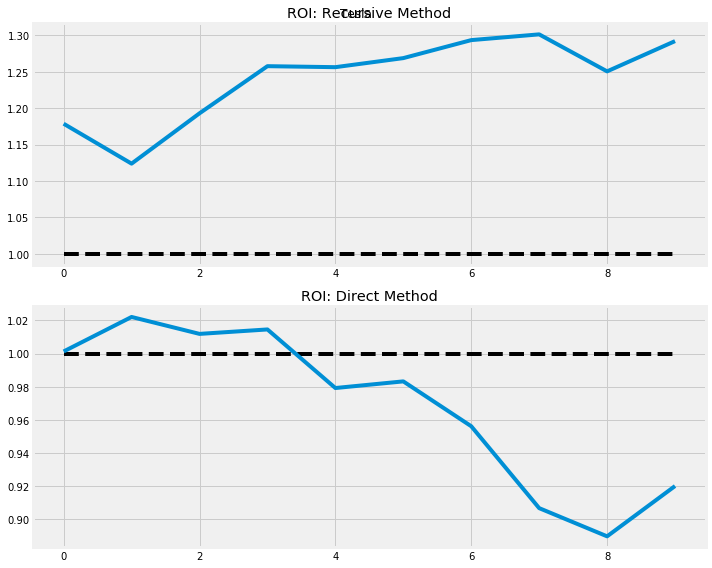

In [94]:
plt.figure(1, figsize=(10,8))
plt.suptitle('Tesla')
plt.subplot(211)
plt.plot(preds/train[-1])
plt.hlines(y=1, xmin=0, xmax=9, color='black', linestyle='--')
plt.title('ROI: Recursive Method')

plt.subplot(212)
plt.title('ROI: Direct Method')
preds_direct = np.array(preds_direct)
plt.plot(preds_direct/train[-1])
plt.hlines(y=1, xmin=0, xmax=9, color='black', linestyle='--')
plt.tight_layout()
plt.show()

This model essentially predicts the opposite of the recursive SARIMA model: of the 10 day horizon only 3 days are predicted to be be gains versus all 10 for the recursive model. This model predicts a slight decrease in closing price for the first day of our horizon, so we should use another metric in combination with this information in deciding to keep or sell this security. In comes the Sharp Ratio, where we use the rate of a 3 month treasury bill in order to calculate excess returns (2.35\% found [here](https://www.cnbc.com/quotes/?symbol=US3M)).

$ S_r = \frac{\hat{r_p}-r_f}{\sigma} $

To finish this article we need to annualize the Sharpe ratio, since we calculated it from daily values. There are 252 trading days in the year, so the simple way to annualize it is to multiply the Sharpe ratio by the square root of 252.

In [54]:
prices = tesla.iloc[:-(n_test+1),1].values
returns = tesla.iloc[:-n_test,1].diff()[1:].values
daily_ret = returns/prices

tesla_sharp = (np.mean(daily_ret) - 0.02354)/np.std(returns)
tesla_sharp = (252**0.5)*tesla_sharp
tesla_sharp

-0.04186010804440901

Using the Sharp Ratio and the forecasted prices I will **sell** this stock (or at the least decrease my position on TSLA).

In [55]:
y_true = tesla[-(n_test+1):-1]['y'].values
y_pred = np.array(preds[-n_test:])
mean_absolute_percentage_error(y_true, y_pred)

1.0032434092699207

Using the direct strategy for multi-step forecasting reduced our mean absolute percentage error to **1.003**! While this is lower than the volatility inherent in the stock data, the rolling Kurtosis values and high volatility would cause me to be skeptical so I would not hold (or even buy in the first place).

## Apple  

**Recursive Method**

In [56]:
mape(apple)

1.1576335302374892

In [95]:
# 1 - split the data
data = apple['y'].values
train, test = data[:-n_test], data[-n_test:]

We again calculate the rolling Kurtosis values (with a window of 5, one business week) as we did above.

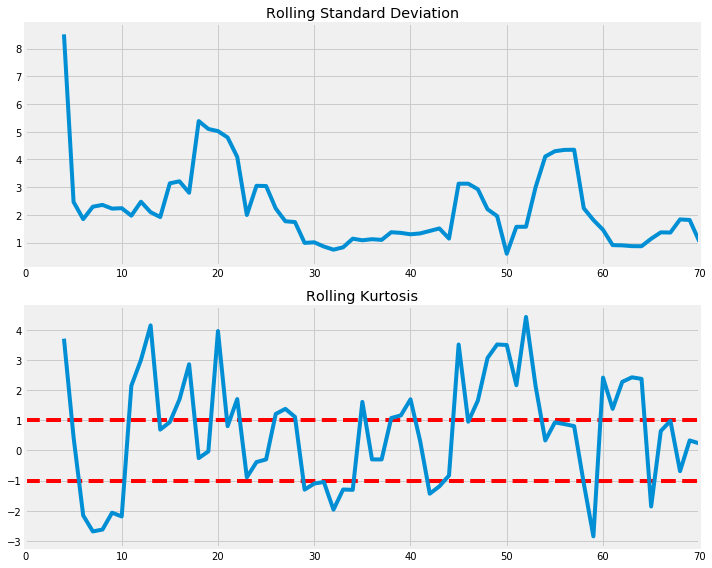

In [58]:
# calculate the returns
returns = np.diff(train)
s = pd.Series(returns)

plt.figure(1, figsize=(10,8))
plt.subplot(211)
s.rolling(5).std().plot()
plt.title('Rolling Standard Deviation')

plt.subplot(212)
plt.title('Rolling Kurtosis')
s.rolling(5).kurt().plot()
plt.hlines(y=1, xmin=0, xmax=71, color='r', linestyle='--')
plt.hlines(y=-1, xmin=0, xmax=71, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [96]:
# 1 - create model
model = SARIMAX(train, order=(1, 1, 1), 
                seasonal_order=(0, 0, 0, 0), 
                trend='c', enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# recursive method
preds = model_fit.predict(1, len(test))
mean_absolute_percentage_error(test, preds_recursive)

27.000518061498692

**Direct Method**

In [101]:
n_test_apple = round(0.2*len(apple))
# model configs
cfg_apple = [(2, 1, 4), (0, 0, 3, 0), 'c']
preds_direct, result = score_model(apple['y'].values, n_test, cfg_apple)

 > Model[[(2, 1, 4), (0, 0, 3, 0), 'c']] 0.646


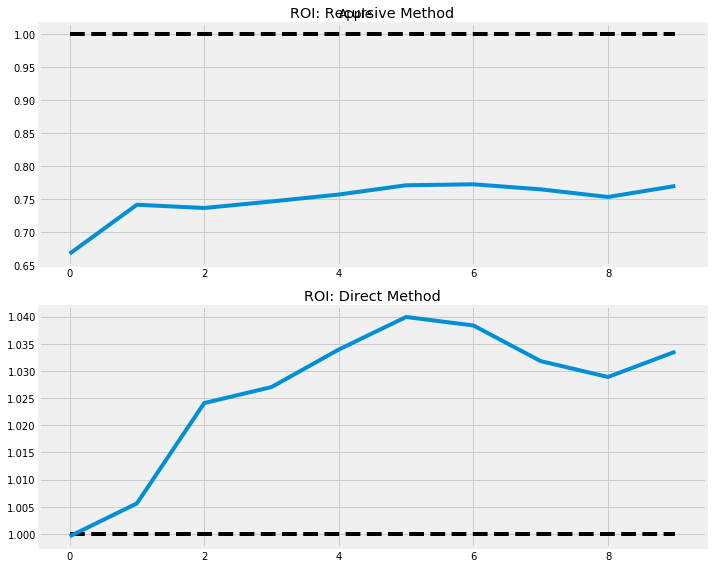

In [103]:
plt.figure(1, figsize=(10,8))
plt.suptitle('Apple')
plt.subplot(211)
plt.plot(preds/train[-1])
plt.hlines(y=1, xmin=0, xmax=9, color='black', linestyle='--')
plt.title('ROI: Recursive Method')

plt.subplot(212)
plt.title('ROI: Direct Method')
preds_direct = np.array(preds_direct)
plt.plot(preds_direct/train[-1])
plt.hlines(y=1, xmin=0, xmax=9, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [34]:
prices = apple.iloc[:-(n_test+1),1].values
returns = apple.iloc[:-n_test,1].diff()[1:].values
daily_ret = returns/prices

apple_sharp = (np.mean(daily_ret) - 0.02354)/np.std(returns)
apple_sharp = (252**0.5)*apple_sharp
apple_sharp

-0.098859863238525

Even though Apple has a lower Sharp Ration than Tesla, the predictions are all greater than the final closing price (train set) so I will **keep** this stock.

In [35]:
y_true = apple[-(n_test+1):-1]['y'].values
y_pred = np.array(preds[-n_test:])
mean_absolute_percentage_error(y_true, y_pred)

25.25624271174955

## Amazon  

**Recursive Method**

In [90]:
mape(amazon)

1.2424392378193525

In [109]:
# 1 - split the data
data = amazon['y'].values
#n_test = int(0.2*len(amazon))
train, test = data[:-n_test], data[-n_test:]

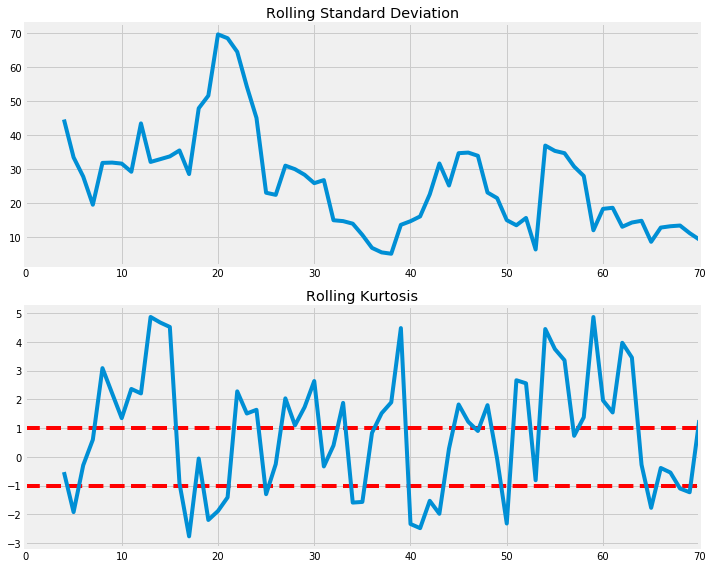

In [110]:
# calculate the returns
returns = np.diff(train)
s = pd.Series(returns)

plt.figure(1, figsize=(10,8))
plt.subplot(211)
s.rolling(5).std().plot()
plt.title('Rolling Standard Deviation')

plt.subplot(212)
plt.title('Rolling Kurtosis')
s.rolling(5).kurt().plot()
plt.hlines(y=1, xmin=0, xmax=71, color='r', linestyle='--')
plt.hlines(y=-1, xmin=0, xmax=71, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [111]:
# 1 - create model
model = SARIMAX(train, order=(1, 1, 1), 
                seasonal_order=(0, 0, 0, 0), 
                trend='c', enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# recursive method
preds = model_fit.predict(1, len(test))
mean_absolute_percentage_error(test, preds)

16.328395882840844

**Direct Method**

In [112]:
# model configs
cfg_amazon = [(0, 1, 3), (3, 0, 4, 0), 'c']

preds_direct, result = score_model(amazon['y'].values, n_test, cfg_amazon)

 > Model[[(0, 1, 3), (3, 0, 4, 0), 'c']] 0.673


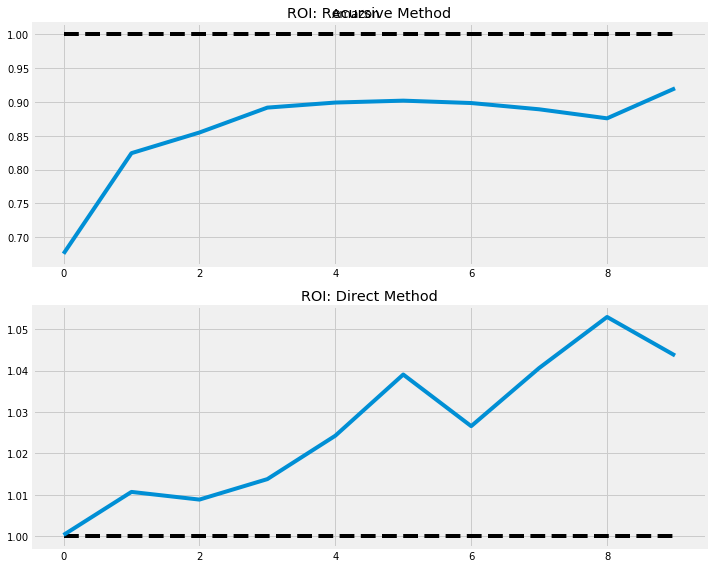

In [113]:
plt.figure(1, figsize=(10,8))
plt.suptitle('Amazon')
plt.subplot(211)
plt.plot(preds/train[-1])
plt.hlines(y=1, xmin=0, xmax=9, color='black', linestyle='--')
plt.title('ROI: Recursive Method')

plt.subplot(212)
plt.title('ROI: Direct Method')
preds_direct = np.array(preds_direct)
plt.plot(preds_direct/train[-1])
plt.hlines(y=1, xmin=0, xmax=9, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [97]:
prices = amazon.iloc[:-(n_test+1),1].values
returns = amazon.iloc[:-n_test,1].diff()[1:].values
daily_ret = returns/prices

amazon_sharp = (np.mean(daily_ret) - 0.02354)/np.std(returns)
amazon_sharp = (252**0.5)*amazon_sharp
amazon_sharp

-0.010822043379343069

While Amazon has an annualized Sharp Ratio that is slightly negative, our model predicts a ROI of close to 7% so I will **keep** this stock.

## General Electric

In [21]:
mape(ge)

2.0928410912824535

In [114]:
# 1 - split the data
data = ge['y'].values
#n_test = int(0.2*len(ge))
train, test = data[:-n_test], data[-n_test:]

**Recursive Method**

In [115]:
# 1 - create model
model = SARIMAX(train, order=(1, 1, 1), 
                seasonal_order=(0, 0, 0, 0), 
                trend='c', enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# recursive method
preds = model_fit.predict(1, len(test))
mean_absolute_percentage_error(test, preds)

13.71542139397268

**Direct Method**

In [117]:
# model configs
cfg_ge = [(1,1,1), (1,0,1,0), 'n']

preds_direct, result = score_model(ge['y'].values, n_test, cfg_ge)

 > Model[[(1, 1, 1), (1, 0, 1, 0), 'n']] 1.823


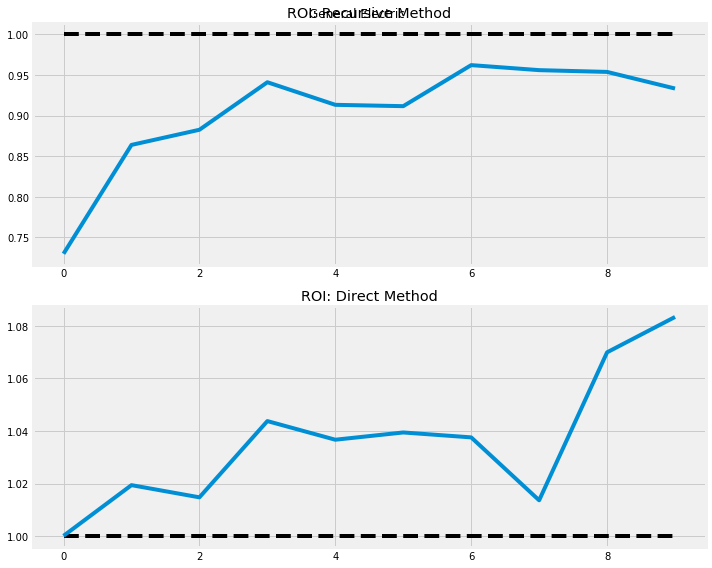

In [118]:
plt.figure(1, figsize=(10,8))
plt.suptitle('General Electric')
plt.subplot(211)
plt.plot(preds/train[-1])
plt.hlines(y=1, xmin=0, xmax=9, color='black', linestyle='--')
plt.title('ROI: Recursive Method')

plt.subplot(212)
plt.title('ROI: Direct Method')
preds_direct = np.array(preds_direct)
plt.plot(preds_direct/train[-1])
plt.hlines(y=1, xmin=0, xmax=9, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [119]:
prices = ge.iloc[:-(n_test+1),1].values
returns = ge.iloc[:-n_test,1].diff()[1:].values
daily_ret = returns/prices

ge_sharp = (np.mean(daily_ret) - 0.02354)/np.std(returns)
ge_sharp = (252**0.5)*ge_sharp
ge_sharp

-1.198426660552849

While GE has a Sharp Ratio of -1, our model suggests that the price will fall significantly but will start to bounce back after 6 days of continual decline so:
  1. As it stands on day 1 of our test period, we are up 25% 
  2. The lowest our model predicts the price will fall to is \\$8.98, which is still 16\% more than our initial purchase
  3. Keep stock

## Boeing

In [25]:
mape(boeing)

1.4021939240457837

In [120]:
# 1 - split the data
data = boeing['y'].values
#n_test = int(0.2*len(boeing))
train, test = data[:-n_test], data[-n_test:]

**Recursive Method**

In [127]:
# 1 - create model
model = SARIMAX(train, order=(1, 1, 1), 
                seasonal_order=(0, 0, 0, 0), 
                trend='c', enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# recursive method
preds = model_fit.predict(1, len(test))
mean_absolute_percentage_error(test, preds)

9.682160484893112

**Direct Method**

In [129]:
# model configs
cfg_boeing = [(1, 1, 3), (2, 0, 3, 0), 'n']

preds_direct, result = score_model(boeing['y'].values, n_test, cfg_boeing)

 > Model[[(1, 1, 3), (2, 0, 3, 0), 'n']] 0.906


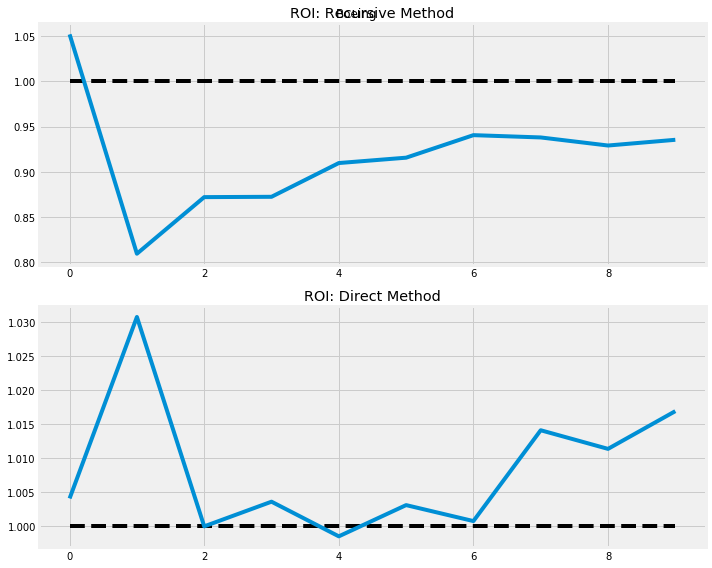

In [131]:
plt.figure(1, figsize=(10,8))
plt.suptitle('Boeing')
plt.subplot(211)
plt.plot(preds/train[-1])
plt.hlines(y=1, xmin=0, xmax=9, color='black', linestyle='--')
plt.title('ROI: Recursive Method')

plt.subplot(212)
plt.title('ROI: Direct Method')
preds_direct = np.array(preds_direct)
plt.plot(preds_direct/train[-1])
plt.hlines(y=1, xmin=0, xmax=9, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [129]:
prices = boeing.iloc[:-(n_test+1),1].values
returns = boeing.iloc[:-n_test,1].diff()[1:].values
daily_ret = returns/prices

boeing_sharp = (np.mean(daily_ret) - 0.02354)/np.std(returns)
boeing_sharp = (252**0.5)*boeing_sharp
boeing_sharp

-0.042204196606691974

In [133]:
(np.min(test)-train[0])/train[0]

0.13268138157251932

Boeing has a slightly negative Sharp Ratio as well, however, the price has risen significantly since our initial purchase (on January 1, 2019) and according to our model at the lowest predicted price we are still set to make over 13\% so we should **keep** this stock.

Using this basic strategy (no allocation optimization) we will see a **19.3**% ROI.

# Conclusion